<a href="https://colab.research.google.com/github/Prisci723/ia2/blob/main/Laboratorio5/LAB_01_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/051_gans/gans.ipynb)

In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Solo mis plantas/Aloe Vera.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
with zipfile.ZipFile('/content/drive/MyDrive/Solo mis plantas/Cedron.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
with zipfile.ZipFile('/content/drive/MyDrive/Solo mis plantas/Higuera.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
with zipfile.ZipFile('/content/drive/MyDrive/Solo mis plantas/Nispero.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
with zipfile.ZipFile('/content/drive/MyDrive/Solo mis plantas/floripondio.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


In [ ]:
import os

# Definir las clases
classes = ['Aloe Vera', 'Cedron', 'Higuera', 'Nispero' , 'floripondio']


# Listas para almacenar rutas de imágenes y sus etiquetas
imgs = []
labels = []

# Iterar sobre las clases
for i, lab in enumerate(classes):
    # Definir el path de la carpeta de la clase actual
    class_path = os.path.join(lab)

    # Verificar si el directorio existe
    if not os.path.isdir(class_path):
        print(f'La carpeta {class_path} no existe.')
        continue

    # Listar todos los archivos en el directorio de la clase
    paths = os.listdir(class_path)

    # Filtrar solo los archivos que terminan en .jpg
    paths = [p for p in paths if p.endswith('.jpg')]

    print(f'Categoría: {lab}. Imágenes: {len(paths)}')

    # Construir las rutas completas de las imágenes y etiquetas
    imgs += [os.path.join(class_path, img) for img in paths]
    labels += [i] * len(paths)

# Ahora imgs contiene las rutas completas de las imágenes y labels contiene las etiquetas correspondientes

Categoría: Aloe Vera. Imágenes: 15106
Categoría: Cedron. Imágenes: 15777
Categoría: Higuera. Imágenes: 15062
Categoría: Nispero. Imágenes: 16154
Categoría: floripondio. Imágenes: 14024


In [ ]:
import torch
from PIL import Image  # Para abrir y redimensionar las imágenes
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels, random_state=42)

# Convertir a formato adecuado para Dataset
trainset = list(zip(train_imgs, train_labels))
testset = list(zip(test_imgs, test_labels))

In [ ]:
# Crear la clase Dataset para entrenamiento y prueba
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

# Crear datasets de entrenamiento y prueba
import albumentations as A
from skimage import io

trans = A.Compose([
    A.Resize(50, 50)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

# Mostrar la cantidad de imágenes de cada conjunto
print(f'Cantidad de imágenes de entrenamiento: {len(dataset["train"])}')
print(f'Cantidad de imágenes de prueba: {len(dataset["test"])}')

Cantidad de imágenes de entrenamiento: 60898
Cantidad de imágenes de prueba: 15225


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
img, label = dataset["train"][10]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([3, 50, 50]), torch.float32, tensor(1.), tensor(0.))

El dataset está formado por 60000 imágenes de baja resolución (50 x 50 píxeles) y contiene 5 tipos de plantas

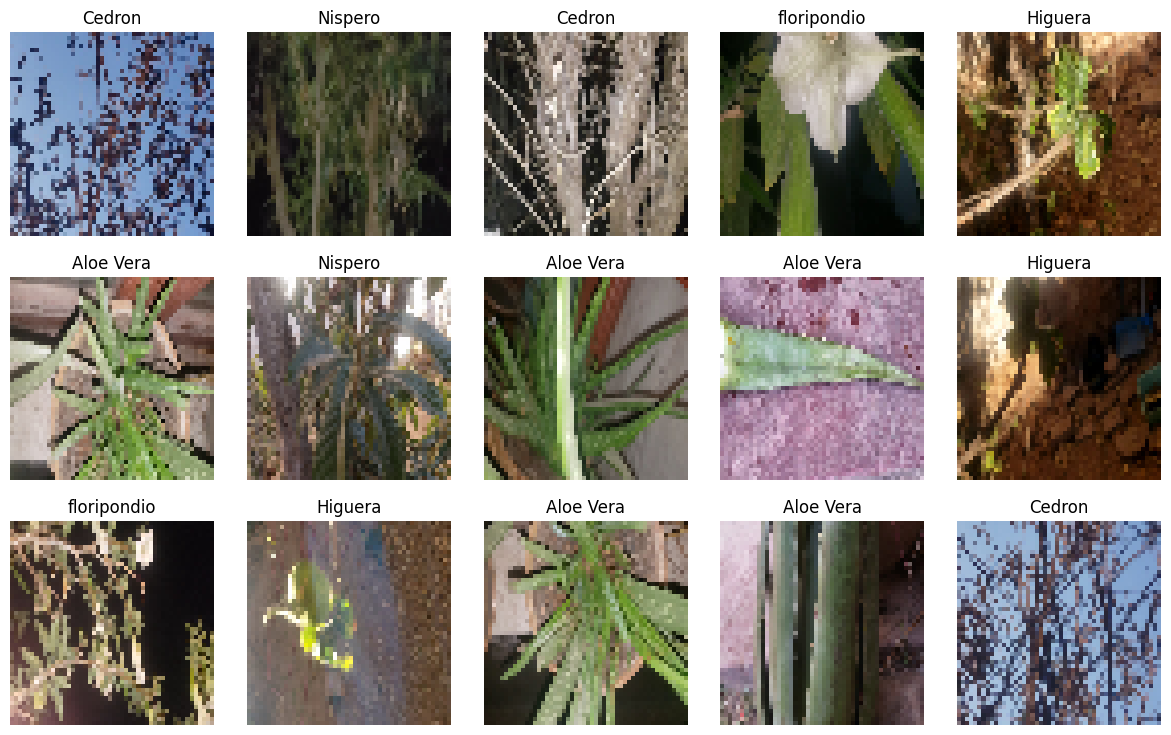

In [ ]:
import random
import matplotlib.pyplot as plt

# Asumiendo que el dataset['train'] es un objeto Dataset que permite la indexación
train = dataset['train']

# Definir el número de filas y columnas
r, c = 3, 5

# Crear una figura para mostrar las imágenes
plt.figure(figsize=(c*3, r*3))

for row in range(r):
    for col in range(c):
        # Índice de la imagen en la cuadrícula
        index = c * row + col
        plt.subplot(r, c, index + 1)

        # Elegir una imagen aleatoria del conjunto de entrenamiento
        ix = random.randint(0, len(train) - 1)

        # Obtener la imagen y la etiqueta del dataset
        img, label = train[ix]

        # Mostrar la imagen (asumiendo que la imagen está en formato [3, 50, 50])
        # Move the tensor to the cpu and convert it to a numpy array
        img_np = img.cpu().numpy()
        # Transpose the image to (50, 50, 3)
        img_np = img_np.transpose(1, 2, 0)
        plt.imshow(img_np, cmap='gray')
        plt.axis('off')  # Ocultar los ejes

        # Mostrar la etiqueta como título (asumiendo que `classes` es una lista con los nombres de las clases)
        plt.title(classes[label.item()])


# Ajuste de los espacios entre imágenes
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Mostrar la figura
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from PIL import Image


In [ ]:
# Constants
INPUT_SIZE = 50 * 50 * 3  # Assuming RGB images
OUTPUT_SIZE = 5  # Number of plant types
LATENT_DIM = 100
BATCH_SIZE = 200
LR = 0.0002
BETAS = (0.5, 0.999)
CHECKPOINT_DIR = "/content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoint GAN"

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def block(in_feat, out_feat, normalize=True):
    layers = [nn.Linear(in_feat, out_feat)]
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat, 0.8))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            block(LATENT_DIM, 128, normalize=False),
            block(128, 256),
            block(256, 512),
            block(512, 1024),
            nn.Linear(1024, INPUT_SIZE),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 50, 50)
        return img

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

    def evaluate_images(self, images):
        """
        Evaluate images without affecting the discriminator's training state.
        """
        original_training_state = self.training
        self.eval()
        with torch.no_grad():
            img_flat = images.view(images.size(0), -1)
            validity = self.model(img_flat)
        self.train(original_training_state)
        return validity

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            block(INPUT_SIZE, 512, normalize=False),
            block(512, 256),
            block(256, 128),
            nn.Linear(128, OUTPUT_SIZE),
            nn.Softmax(dim=1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


In [ ]:
transform = A.Compose([
    A.Resize(50, 50),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

class PlantDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert image to numpy array if it's not already
        if isinstance(image, Image.Image):
            image = np.array(image)
        elif isinstance(image, str):  # Assume it's a file path
            image = np.array(Image.open(image))
        elif not isinstance(image, np.ndarray):
            raise TypeError(f"Unsupported image type: {type(image)}. Expected numpy array, PIL Image, or file path.")

        # Ensure image is in RGB format
        if image.ndim == 2:  # Grayscale image
            image = np.stack((image,)*3, axis=-1)
        elif image.shape[2] == 4:  # RGBA image
            image = image[:,:,:3]

        if self.transform:
            try:
                augmented = self.transform(image=image)
                image = augmented['image']
            except Exception as e:
                print(f"Error applying transform to image at index {idx}. Error: {str(e)}")
                raise

        return image, label


In [ ]:
# Assuming train_imgs, train_labels, test_imgs, test_labels are already defined
train_dataset = PlantDataset(train_imgs, train_labels, transform)
test_dataset = PlantDataset(test_imgs, test_labels, transform)

# Use fewer workers to avoid potential issues with multiprocessing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Initialize models
generator = Generator()
discriminator = Discriminator(INPUT_SIZE)
classifier = Classifier()

# Apply weight initialization
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
classifier.apply(weights_init_normal)

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
classifier.to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=BETAS)
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=BETAS)
optimizer_C = optim.Adam(classifier.parameters(), lr=LR, betas=BETAS)

# Learning rate schedulers
scheduler_G = ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=5, verbose=True)
scheduler_D = ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=5, verbose=True)
scheduler_C = ReduceLROnPlateau(optimizer_C, mode='min', factor=0.5, patience=5, verbose=True)

# Loss functions
adversarial_loss = nn.BCELoss()
classification_loss = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def save_checkpoint(epoch, g_loss, d_loss, c_loss):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"checkpoint_epoch{epoch}_{timestamp}.pth")
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'classifier_state_dict': classifier.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'optimizer_C_state_dict': optimizer_C.state_dict(),
        'g_loss': g_loss,
        'd_loss': d_loss,
        'c_loss': c_loss,
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    classifier.load_state_dict(checkpoint['classifier_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    optimizer_C.load_state_dict(checkpoint['optimizer_C_state_dict'])
    epoch = checkpoint['epoch']
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    c_loss = checkpoint['c_loss']
    print(f"Checkpoint loaded: epoch {epoch}")
    return epoch, g_loss, d_loss, c_loss


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np


In [ ]:
# Add TensorBoard writer
writer = SummaryWriter(log_dir=os.path.join(CHECKPOINT_DIR, 'tensorboard_logs'))

# ... (Generator, Discriminator, Classifier, and other previous code remain the same)

def save_loss_plot(g_losses, d_losses, c_losses, epoch):
    plt.figure(figsize=(10, 5))
    plt.title("Generator, Discriminator, and Classifier Loss During Training")
    plt.plot(g_losses, label="Generator")
    plt.plot(d_losses, label="Discriminator")
    plt.plot(c_losses, label="Classifier")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(CHECKPOINT_DIR, f'loss_plot_epoch_{epoch}.png'))
    plt.close()

def display_generated_images(images, epoch, n=16, size=(4, 4)):
    grid = make_grid(images[:n], nrow=size[0], normalize=True)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_axis_off()
    ax.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Generated Images - Epoch {epoch}")
    plt.savefig(os.path.join(CHECKPOINT_DIR, f'generated_images_epoch_{epoch}.png'))
    plt.close()


In [ ]:

def show_images(images, num_images=16, size=(4, 4), title=None):
    """Display a grid of images inline."""
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()

    images = (images * 255).astype(np.uint8)
    if images.shape[1] == 3:  # If channels are in the second dimension (PyTorch style)
        images = np.transpose(images, (0, 2, 3, 1))

    fig, axes = plt.subplots(size[0], size[1], figsize=(15, 15))
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.set_visible(False)
    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

def visualize_dataset_samples(dataset, num_samples=16):
    """Visualize random samples from the dataset."""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    images = [dataset[i][0] for i in indices]  # Assuming dataset returns (image, label)
    images = torch.stack(images)
    show_images(images, num_images=num_samples, title="Dataset Samples")

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm.notebook import tqdm

In [ ]:
def train(epochs, start_epoch=0):
    g_losses, d_losses, c_losses = [], [], []
    best_g_loss = float('inf')

    # Learning rate schedulers
    scheduler_G = ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=5, verbose=True)
    scheduler_D = ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=5, verbose=True)
    scheduler_C = ReduceLROnPlateau(optimizer_C, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(start_epoch, epochs):
        generator.train()
        discriminator.train()
        classifier.train()

        epoch_g_losses, epoch_d_losses, epoch_c_losses = [], [], []

        # Use tqdm for a progress bar
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for i, (real_imgs, labels) in pbar:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()

            z = torch.randn(batch_size, LATENT_DIM).to(device)
            fake_imgs = generator(z)

            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs.detach())

            real_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)

            real_loss = adversarial_loss(real_validity, real_label)
            fake_loss = adversarial_loss(fake_validity, fake_label)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            gen_imgs = generator(z)
            fake_validity = discriminator(gen_imgs)

            g_loss = adversarial_loss(fake_validity, real_label)

            g_loss.backward()
            optimizer_G.step()

            # Train Classifier
            optimizer_C.zero_grad()

            pred_labels = classifier(real_imgs)
            c_loss = classification_loss(pred_labels, labels)

            c_loss.backward()
            optimizer_C.step()

            # Save losses
            epoch_g_losses.append(g_loss.item())
            epoch_d_losses.append(d_loss.item())
            epoch_c_losses.append(c_loss.item())

            # Update progress bar
            pbar.set_postfix({
                'G_loss': f"{g_loss.item():.4f}",
                'D_loss': f"{d_loss.item():.4f}",
                'C_loss': f"{c_loss.item():.4f}"
            })

            # Visualize every 100 batches
            if i % 100 == 0:
                visualize_progress(epoch, i, real_imgs, gen_imgs, g_losses, d_losses, c_losses)

        # Calculate average epoch losses
        avg_g_loss = np.mean(epoch_g_losses)
        avg_d_loss = np.mean(epoch_d_losses)
        avg_c_loss = np.mean(epoch_c_losses)

        # Update learning rates
        scheduler_G.step(avg_g_loss)
        scheduler_D.step(avg_d_loss)
        scheduler_C.step(avg_c_loss)

        # Save best model
        if avg_g_loss < best_g_loss:
            best_g_loss = avg_g_loss
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'classifier_state_dict': classifier.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'optimizer_C_state_dict': optimizer_C.state_dict(),
            }, 'best_model.pth')

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] Avg losses: G: {avg_g_loss:.4f}, D: {avg_d_loss:.4f}, C: {avg_c_loss:.4f}")

        # Append to overall losses for plotting
        g_losses.extend(epoch_g_losses)
        d_losses.extend(epoch_d_losses)
        c_losses.extend(epoch_c_losses)

    # Final visualization
    visualize_progress(epochs-1, len(train_loader)-1, real_imgs, gen_imgs, g_losses, d_losses, c_losses, final=True)


In [ ]:
def show_images(images, num_images=16, size=(4, 4), title=None):
    """Display a grid of images inline."""
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()

    images = (images * 255).astype(np.uint8)
    if images.shape[1] == 3:  # If channels are in the second dimension (PyTorch style)
        images = np.transpose(images, (0, 2, 3, 1))

    fig, axes = plt.subplots(size[0], size[1], figsize=(15, 15))
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.set_visible(False)
    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

def visualize_dataset_samples(dataset, num_samples=16):
    """Visualize random samples from the dataset."""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    images = [dataset[i][0] for i in indices]  # Assuming dataset returns (image, label)
    images = torch.stack(images)
    show_images(images, num_images=num_samples, title="Dataset Samples")


In [ ]:
def visualize_progress(epoch, batch, real_imgs, gen_imgs, g_losses, d_losses, c_losses, final=False):
    clear_output(wait=True)
    fig = plt.figure(figsize=(20, 10))

    # Plot real images
    ax = fig.add_subplot(2, 3, 1)
    ax.set_title("Real Images")
    ax.imshow(np.transpose(make_grid(real_imgs[:16], nrow=4, normalize=True).cpu(), (1, 2, 0)))
    ax.axis('off')

    # Plot generated images
    ax = fig.add_subplot(2, 3, 2)
    ax.set_title("Generated Images")
    ax.imshow(np.transpose(make_grid(gen_imgs[:16], nrow=4, normalize=True).cpu(), (1, 2, 0)))
    ax.axis('off')

    # Plot losses
    ax = fig.add_subplot(2, 3, 3)
    ax.set_title("Losses")
    ax.plot(g_losses, label='Generator')
    ax.plot(d_losses, label='Discriminator')
    ax.plot(c_losses, label='Classifier')
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")
    ax.legend()

    if final:
        plt.suptitle(f"Final Results", fontsize=16)
    else:
        plt.suptitle(f"Epoch {epoch+1}, Batch {batch+1}", fontsize=16)

    plt.tight_layout()
    display(plt.gcf())
    plt.close()


Visualizing dataset samples:


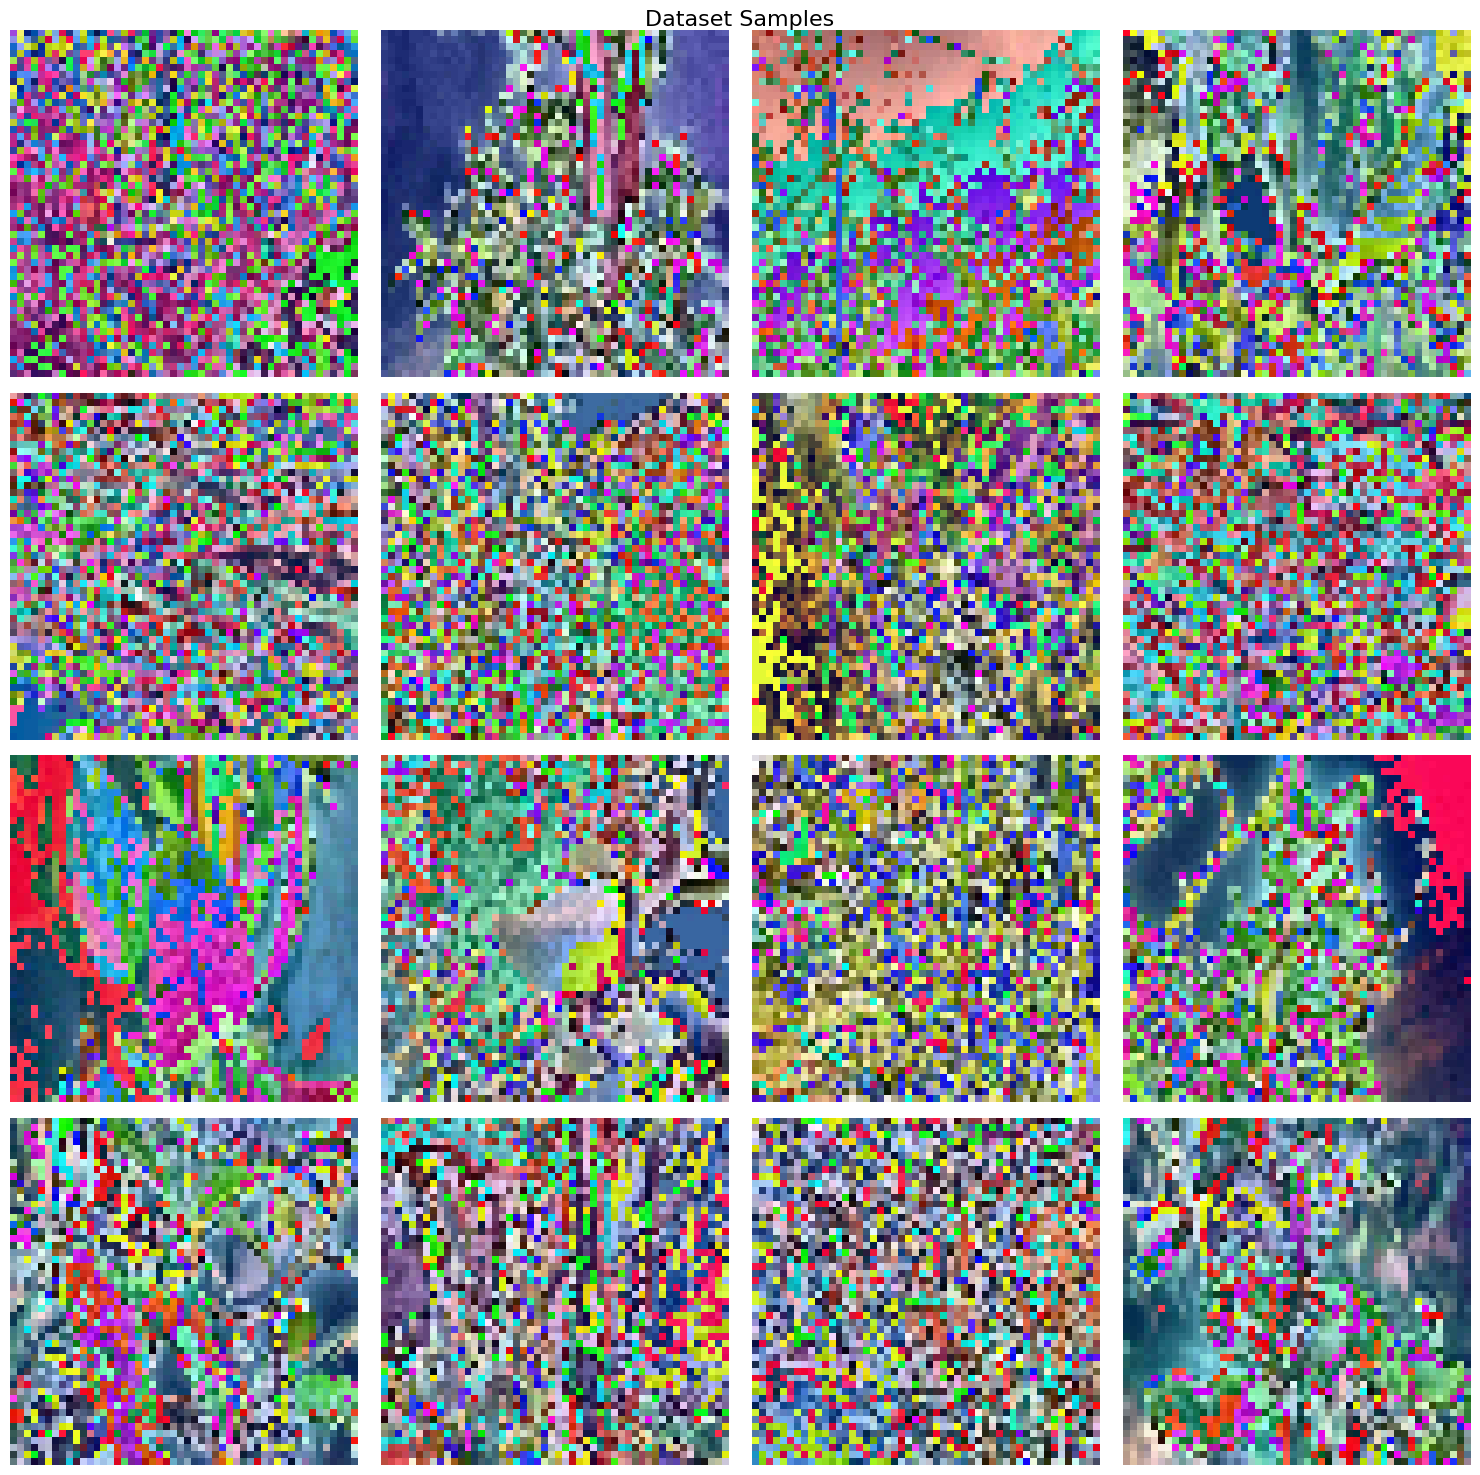

In [ ]:

# Visualize some samples from the dataset before training
print("Visualizing dataset samples:")
visualize_dataset_samples(train_dataset)


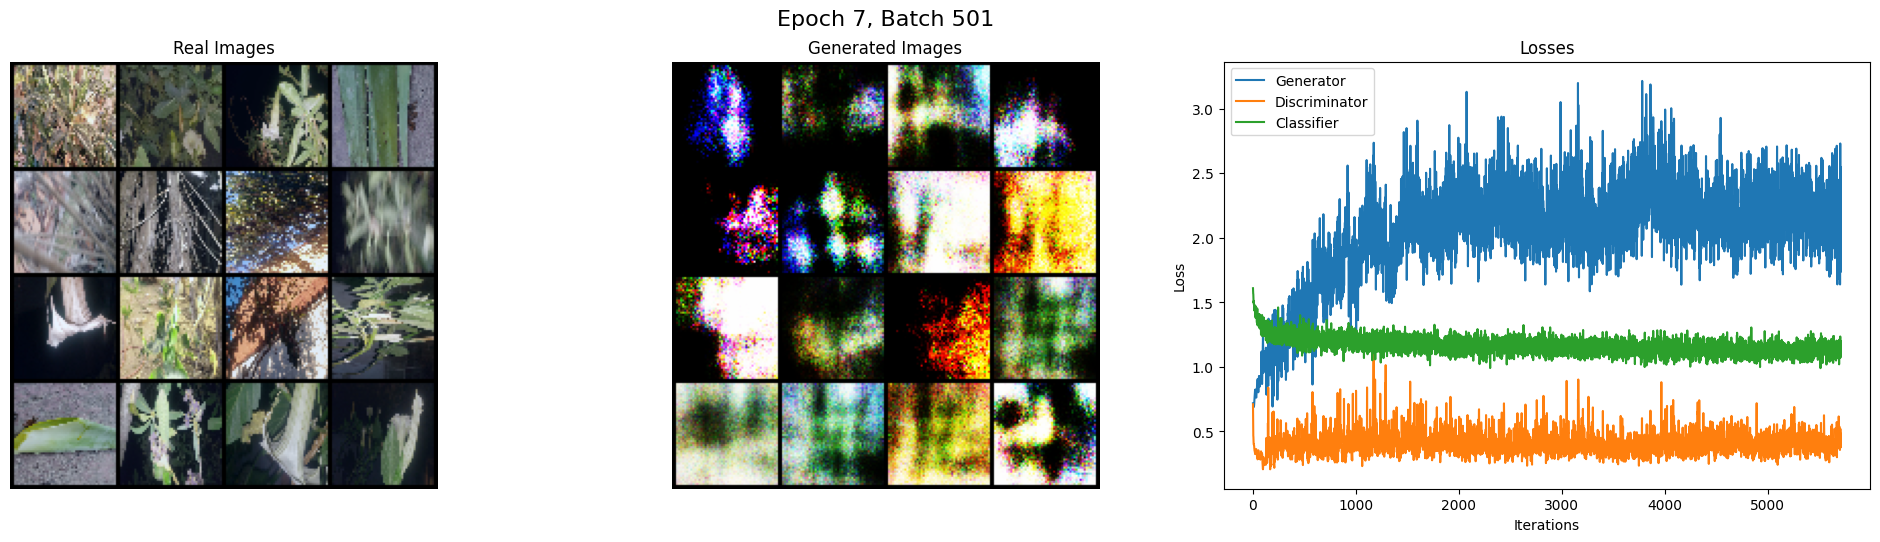

In [ ]:
try:
    train(epochs=50)
except Exception as e:
    print(f"An error occurred during training: {str(e)}")

In [ ]:
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    return checkpoint

def resume_training(checkpoint_path, generator, discriminator, classifier, optimizer_G, optimizer_D, optimizer_C):
    checkpoint = load_checkpoint(checkpoint_path)

    # Load model states
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    classifier.load_state_dict(checkpoint['classifier_state_dict'])

    # Load optimizer states
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    optimizer_C.load_state_dict(checkpoint['optimizer_C_state_dict'])

    # Get the epoch where we left off
    start_epoch = checkpoint['epoch'] + 1

    return start_epoch

# Assuming you have already defined your models and optimizers
generator = Generator()  # Your generator model
discriminator = Discriminator(INPUT_SIZE)  # Your discriminator model
classifier = Classifier()  # Your classifier model
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_C = torch.optim.Adam(classifier.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load the checkpoint and resume training
checkpoint_path = '/content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoint GAN/checkpoint_epoch77_20240914_165027.pth'
start_epoch = resume_training(checkpoint_path, generator, discriminator, classifier, optimizer_G, optimizer_D, optimizer_C)



<ipython-input-15-647d54e77708>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [ ]:
def train(epochs, start_epoch=0, checkpoint_path=None):
    g_losses, d_losses, c_losses = [], [], []

    # Learning rate schedulers
    scheduler_G = ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=5, verbose=True)
    scheduler_D = ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=5, verbose=True)
    scheduler_C = ReduceLROnPlateau(optimizer_C, mode='min', factor=0.5, patience=5, verbose=True)

    # Load checkpoint if provided
    if checkpoint_path:
        start_epoch, last_g_loss, last_d_loss, last_c_loss = load_checkpoint(checkpoint_path)
        g_losses = [last_g_loss]
        d_losses = [last_d_loss]
        c_losses = [last_c_loss]

    for epoch in range(start_epoch, epochs):
        generator.train()
        discriminator.train()
        classifier.train()

        epoch_g_losses, epoch_d_losses, epoch_c_losses = [], [], []

        # Use tqdm for a progress bar
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for i, (real_imgs, labels) in pbar:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()

            z = torch.randn(batch_size, LATENT_DIM).to(device)
            fake_imgs = generator(z)

            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs.detach())

            real_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)

            real_loss = adversarial_loss(real_validity, real_label)
            fake_loss = adversarial_loss(fake_validity, fake_label)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            gen_imgs = generator(z)
            fake_validity = discriminator(gen_imgs)

            g_loss = adversarial_loss(fake_validity, real_label)

            g_loss.backward()
            optimizer_G.step()

            # Train Classifier
            optimizer_C.zero_grad()

            pred_labels = classifier(real_imgs)
            c_loss = classification_loss(pred_labels, labels)

            c_loss.backward()
            optimizer_C.step()

            # Save losses
            epoch_g_losses.append(g_loss.item())
            epoch_d_losses.append(d_loss.item())
            epoch_c_losses.append(c_loss.item())

            # Update progress bar
            pbar.set_postfix({
                'G_loss': f"{g_loss.item():.4f}",
                'D_loss': f"{d_loss.item():.4f}",
                'C_loss': f"{c_loss.item():.4f}"
            })

            # Visualize every 100 batches
            if i % 100 == 0:
                visualize_progress(epoch, i, real_imgs, gen_imgs, g_losses, d_losses, c_losses)

        # Calculate average epoch losses
        avg_g_loss = np.mean(epoch_g_losses)
        avg_d_loss = np.mean(epoch_d_losses)
        avg_c_loss = np.mean(epoch_c_losses)

        # Update learning rates
        scheduler_G.step(avg_g_loss)
        scheduler_D.step(avg_d_loss)
        scheduler_C.step(avg_c_loss)

        # Save checkpoint every 3 epochs
        if (epoch + 1) % 3 == 0:
            save_checkpoint(epoch, avg_g_loss, avg_d_loss, avg_c_loss)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] Avg losses: G: {avg_g_loss:.4f}, D: {avg_d_loss:.4f}, C: {avg_c_loss:.4f}")

        # Append to overall losses for plotting
        g_losses.extend(epoch_g_losses)
        d_losses.extend(epoch_d_losses)
        c_losses.extend(epoch_c_losses)

    # Final visualization
    visualize_progress(epochs-1, len(train_loader)-1, real_imgs, gen_imgs, g_losses, d_losses, c_losses, final=True)


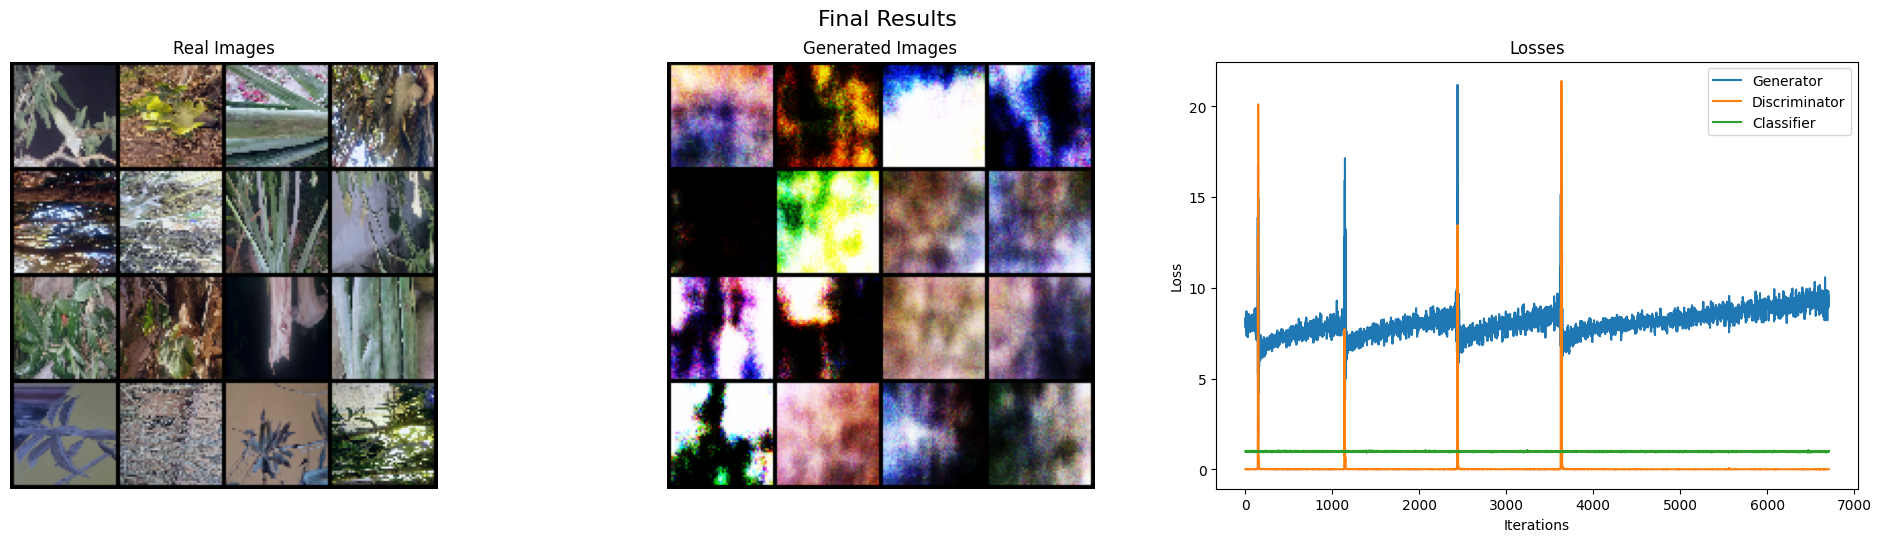

In [ ]:
# Now you can call your train function with the updated start_epoch
train(epochs=100, start_epoch=start_epoch)

In [ ]:
def generate_and_display_images(generator, discriminator, num_images=24, latent_dim=100):
    """
    Generate new images using the trained generator, evaluate them with the discriminator,
    and display them in Google Colab.

    :param generator: Trained generator model
    :param discriminator: Trained discriminator model
    :param num_images: Number of images to generate
    :param latent_dim: Dimension of the latent space
    """
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        # Generate random noise
        z = torch.randn(num_images, latent_dim)

        # Generate images
        generated_images = generator(z)

        # Evaluate images with discriminator
        scores = discriminator(generated_images).squeeze().cpu().numpy()

    # Create a grid of images
    img_grid = make_grid(generated_images, nrow=4, normalize=True)

    # Create the figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    fig.suptitle("Generated Images", fontsize=16)

    # Display the images
    ax1.imshow(np.transpose(img_grid.cpu(), (1, 2, 0)))
    ax1.axis('off')

    # Display the scores
    ax2.bar(range(len(scores)), scores)
    ax2.set_xlabel("Image Index")
    ax2.set_ylabel("Discriminator Score")
    ax2.set_title("Discriminator Scores for Generated Images")

    plt.tight_layout()
    plt.show()



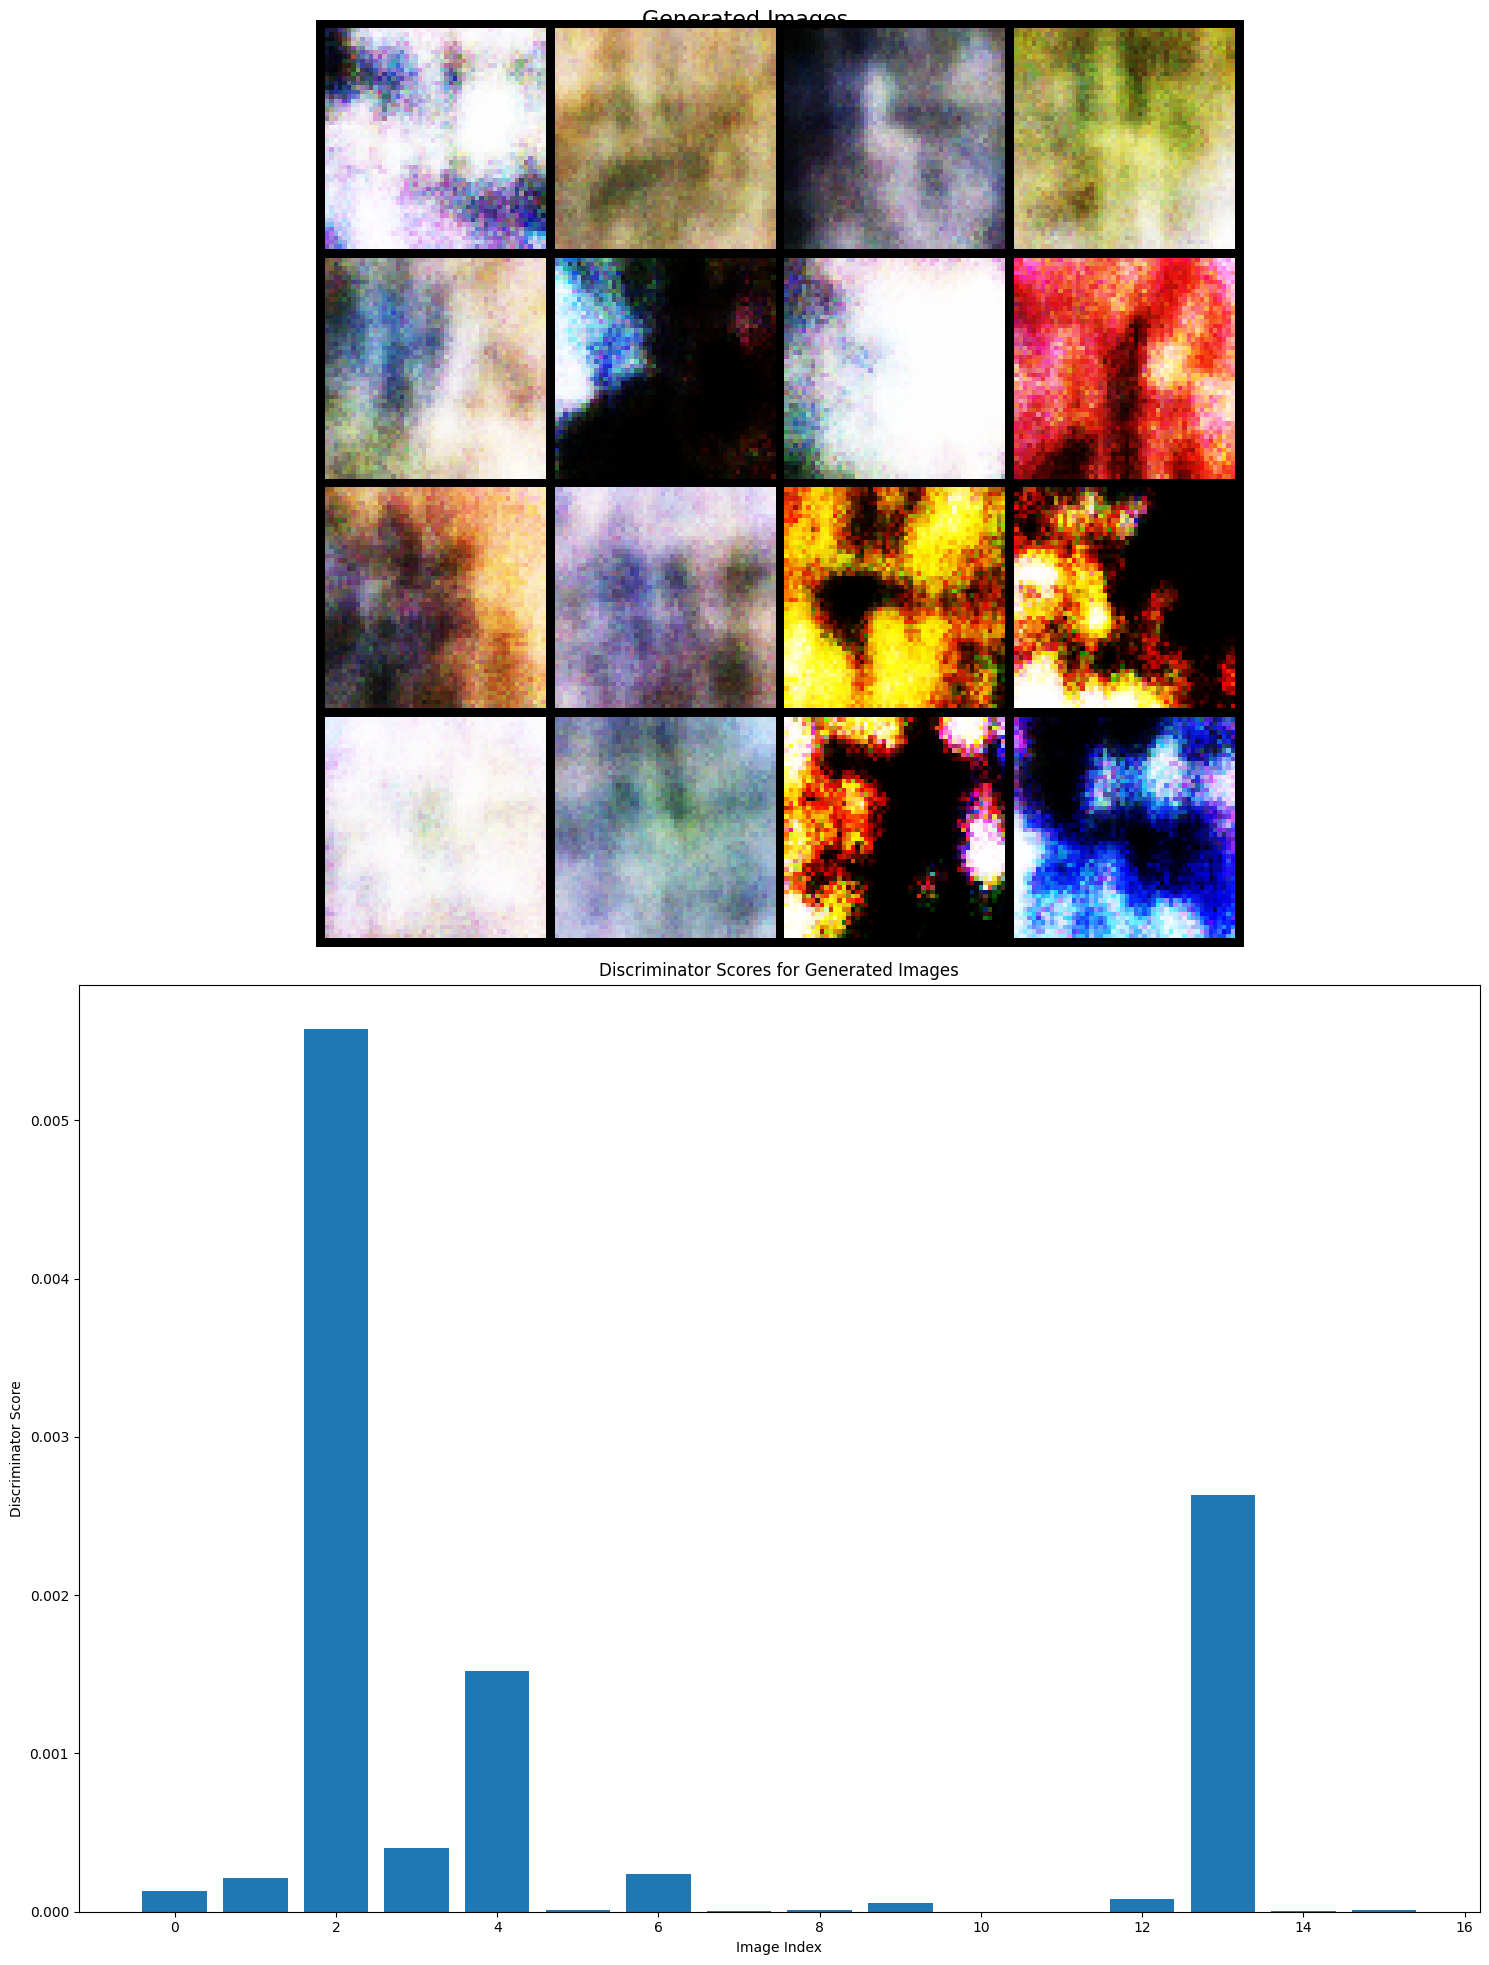

In [ ]:
# Usage in Google Colab:
# Assuming you have your trained generator and discriminator
generate_and_display_images(generator, discriminator)

In [ ]:
import random # imports the random module
import os
import numpy as np
from PIL import Image

In [ ]:
def cargar_dataset_train_leaves(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []
    etiquetas_mapping = {}

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')
                    # Normalizar la imagen
                    imagen = np.array(imagen) / 255.0
                    # Convertir la imagen normalizada a objeto PIL
                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))
                    # Redimensionar imagen
                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                    dataset.append((imagen_resized, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    return dataset

In [ ]:
trainset_leaves = cargar_dataset_train_leaves('/content/drive/MyDrive/SIS421 prueba dataset 1')

print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset_leaves))
# print("Número de ejemplos en el conjunto de prueba:", len(testset))

Número de ejemplos en el conjunto de entrenamiento: 11158


In [ ]:
# Ejemplo de cómo definir la lista de clases
classes = ['Aloe Vera', 'Cedron', 'Floripondio', 'Higuera', 'Nispero']

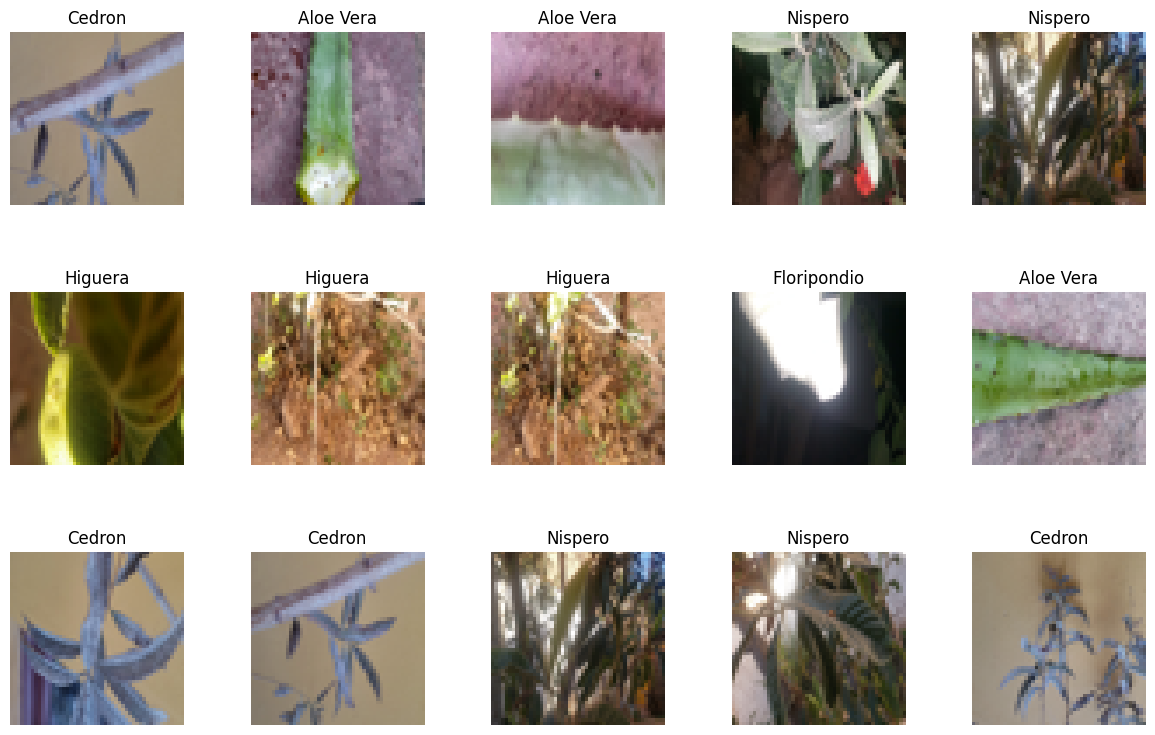

In [ ]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset_leaves)-1)
        img, label = trainset_leaves[ix]
        #print(label)
        #clase_index = classes.index(clase)
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split # imports train_test_split

In [ ]:
# Convertir las imágenes y etiquetas a arrays de NumPy
images_leaves = np.array([np.array(img) for img, label in trainset_leaves])
labels_leaves = np.array([label for img, label in trainset_leaves])

# Dividir los datos en 85% entrenamiento y 15% prueba
train_images_leaves, test_images_leaves, train_labels_leaves, test_labels_leaves = train_test_split(
    images_leaves, labels_leaves, test_size=0.15, random_state=42
)

# Opcional: convertir nuevamente a arrays de NumPy si necesitas
train_images_leaves = np.array(train_images_leaves)
test_images_leaves = np.array(test_images_leaves)
train_labels_leaves = np.array(train_labels_leaves)
test_labels_leaves = np.array(test_labels_leaves)

In [ ]:
BATCH_SIZE2 = 64

In [ ]:
# Assuming train_imgs, train_labels, test_imgs, test_labels are already defined
train_dataset = PlantDataset(train_images_leaves, train_labels_leaves, transform)
test_dataset = PlantDataset(test_images_leaves, test_labels_leaves, transform)

# Use fewer workers to avoid potential issues with multiprocessing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE2, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE2, shuffle=False, num_workers=2, pin_memory=True)

# Initialize models
generator = Generator()
discriminator = Discriminator(INPUT_SIZE)
classifier = Classifier()

# Apply weight initialization
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
classifier.apply(weights_init_normal)

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
classifier.to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=BETAS)
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=BETAS)
optimizer_C = optim.Adam(classifier.parameters(), lr=LR, betas=BETAS)

# Learning rate schedulers
scheduler_G = ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=5, verbose=True)
scheduler_D = ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=5, verbose=True)
scheduler_C = ReduceLROnPlateau(optimizer_C, mode='min', factor=0.5, patience=5, verbose=True)

# Loss functions
adversarial_loss = nn.BCELoss()
classification_loss = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    return checkpoint

def resume_training(checkpoint_path, generator, discriminator, classifier, optimizer_G, optimizer_D, optimizer_C):
    checkpoint = load_checkpoint(checkpoint_path)

    # Load model states
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    classifier.load_state_dict(checkpoint['classifier_state_dict'])

    # Load optimizer states
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    optimizer_C.load_state_dict(checkpoint['optimizer_C_state_dict'])

    # Get the epoch where we left off
    start_epoch = checkpoint['epoch'] + 1

    return start_epoch

# Assuming you have already defined your models and optimizers
generator = Generator()  # Your generator model
discriminator = Discriminator(INPUT_SIZE)  # Your discriminator model
classifier = Classifier()  # Your classifier model
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_C = torch.optim.Adam(classifier.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load the checkpoint and resume training
checkpoint_path = '/content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoint GAN/checkpoint_epoch26_20240915_031116.pth'
start_epoch = resume_training(checkpoint_path, generator, discriminator, classifier, optimizer_G, optimizer_D, optimizer_C)


<ipython-input-29-fe1d386e83aa>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [ ]:
from IPython.display import clear_output, display

class BestImageTracker:
    def __init__(self, k=10):
        self.k = k
        self.best_images = None
        self.best_scores = None

    def update(self, gen_imgs, eval_func):
        with torch.no_grad():  # Add this line
            scores = eval_func(gen_imgs).squeeze().cpu().numpy()

        if self.best_images is None:
            self.best_images = gen_imgs.detach().cpu()[:self.k]
            self.best_scores = scores[:self.k]
        else:
            all_images = torch.cat([self.best_images, gen_imgs.cpu()])
            all_scores = np.concatenate([self.best_scores, scores])

            top_k_indices = np.argsort(all_scores)[-self.k:]
            self.best_images = all_images[top_k_indices]
            self.best_scores = all_scores[top_k_indices]

    def get_best_images(self):
        return self.best_images

def visualize_progress(epoch, batch, real_imgs, gen_imgs, g_losses, d_losses, c_losses, best_image_tracker, final=False):
    clear_output(wait=True)
    fig = plt.figure(figsize=(20, 15))

    # Plot real images
    ax = fig.add_subplot(3, 3, 1)
    ax.set_title("Real Images")
    ax.imshow(np.transpose(make_grid(real_imgs[:16], nrow=4, normalize=True).cpu(), (1, 2, 0)))
    ax.axis('off')

    # Plot generated images
    ax = fig.add_subplot(3, 3, 2)
    ax.set_title("Generated Images")
    ax.imshow(np.transpose(make_grid(gen_imgs[:16], nrow=4, normalize=True).cpu(), (1, 2, 0)))
    ax.axis('off')

    # Plot best generated images
    ax = fig.add_subplot(3, 3, 3)
    ax.set_title("Best Generated Images")
    ax.imshow(np.transpose(make_grid(best_image_tracker.best_images, nrow=4, normalize=True).cpu(), (1, 2, 0)))
    ax.axis('off')

    # Plot losses
    ax = fig.add_subplot(3, 3, 4)
    ax.set_title("Losses")
    ax.plot(g_losses, label='Generator')
    ax.plot(d_losses, label='Discriminator')
    ax.plot(c_losses, label='Classifier')
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")
    ax.legend()

    # Plot discriminator scores for best images
    ax = fig.add_subplot(3, 3, 5)
    ax.set_title("Discriminator Scores for Best Images")
    ax.bar(range(len(best_image_tracker.best_scores)), best_image_tracker.best_scores)
    ax.set_xlabel("Image Index")
    ax.set_ylabel("Discriminator Score")

    if final:
        plt.suptitle(f"Final Results", fontsize=16)
    else:
        plt.suptitle(f"Epoch {epoch+1}, Batch {batch+1}", fontsize=16)

    plt.tight_layout()
    display(plt.gcf())
    plt.close()

In [ ]:
best_image_tracker = BestImageTracker()

In [ ]:
def update(self, gen_imgs, eval_func):
        scores = eval_func(gen_imgs).squeeze().cpu().detach().numpy() # Detach the tensor from the computation graph

        if self.best_images is None:
            self.best_images = gen_imgs[:self.num_best].cpu()
            self.best_scores = scores[:self.num_best]
        else:
            all_images = torch.cat([self.best_images, gen_imgs.cpu()])
            all_scores = np.concatenate([self.best_scores, scores])

            best_indices = np.argsort(all_scores)[-self.num_best:]
            self.best_images = all_images[best_indices]
            self.best_scores = all_scores[best_indices]

In [ ]:
def train(epochs, start_epoch=0, checkpoint_path=None):
    g_losses, d_losses, c_losses = [], [], []

    # Learning rate schedulers
    scheduler_G = ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=5, verbose=True)
    scheduler_D = ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=5, verbose=True)
    scheduler_C = ReduceLROnPlateau(optimizer_C, mode='min', factor=0.5, patience=5, verbose=True)

    # Load checkpoint if provided
    if checkpoint_path:
        start_epoch, last_g_loss, last_d_loss, last_c_loss = load_checkpoint(checkpoint_path)
        g_losses = [last_g_loss]
        d_losses = [last_d_loss]
        c_losses = [last_c_loss]

    for epoch in range(start_epoch, epochs):
        generator.train()
        discriminator.train()
        classifier.train()

        epoch_g_losses, epoch_d_losses, epoch_c_losses = [], [], []

        # Use tqdm for a progress bar
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for i, (real_imgs, labels) in pbar:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

          # Generate fake images
            z = torch.randn(batch_size, LATENT_DIM).to(device)
            fake_imgs = generator(z)

          # Update the best image tracker
            best_image_tracker.update(fake_imgs, discriminator)

            # Train Discriminator
            optimizer_D.zero_grad()

            z = torch.randn(batch_size, LATENT_DIM).to(device)
            fake_imgs = generator(z)

            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs.detach())

            real_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)

            real_loss = adversarial_loss(real_validity, real_label)
            fake_loss = adversarial_loss(fake_validity, fake_label)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            gen_imgs = generator(z)
            fake_validity = discriminator(gen_imgs)

            g_loss = adversarial_loss(fake_validity, real_label)

            g_loss.backward()
            optimizer_G.step()

            # Train Classifier
            optimizer_C.zero_grad()

            pred_labels = classifier(real_imgs)
            c_loss = classification_loss(pred_labels, labels)

            c_loss.backward()
            optimizer_C.step()

            # Save losses
            epoch_g_losses.append(g_loss.item())
            epoch_d_losses.append(d_loss.item())
            epoch_c_losses.append(c_loss.item())

            # Update progress bar
            pbar.set_postfix({
                'G_loss': f"{g_loss.item():.4f}",
                'D_loss': f"{d_loss.item():.4f}",
                'C_loss': f"{c_loss.item():.4f}"
            })

            # Visualize every 100 batches
        # Visualize every 100 batches
            if i % 100 == 0:
                  visualize_progress(epoch, i, real_imgs, fake_imgs, g_losses, d_losses, c_losses, best_image_tracker)

        # Calculate average epoch losses
        avg_g_loss = np.mean(epoch_g_losses)
        avg_d_loss = np.mean(epoch_d_losses)
        avg_c_loss = np.mean(epoch_c_losses)

        # Update learning rates
        scheduler_G.step(avg_g_loss)
        scheduler_D.step(avg_d_loss)
        scheduler_C.step(avg_c_loss)

        # Save checkpoint every 3 epochs
        if (epoch + 1) % 10 == 0:
            save_checkpoint(epoch, avg_g_loss, avg_d_loss, avg_c_loss)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] Avg losses: G: {avg_g_loss:.4f}, D: {avg_d_loss:.4f}, C: {avg_c_loss:.4f}")

        # Append to overall losses for plotting
        g_losses.extend(epoch_g_losses)
        d_losses.extend(epoch_d_losses)
        c_losses.extend(epoch_c_losses)
      # Final visualization
    visualize_progress(epochs-1, len(train_loader)-1, real_imgs, fake_imgs, g_losses, d_losses, c_losses, best_image_tracker, final=True)

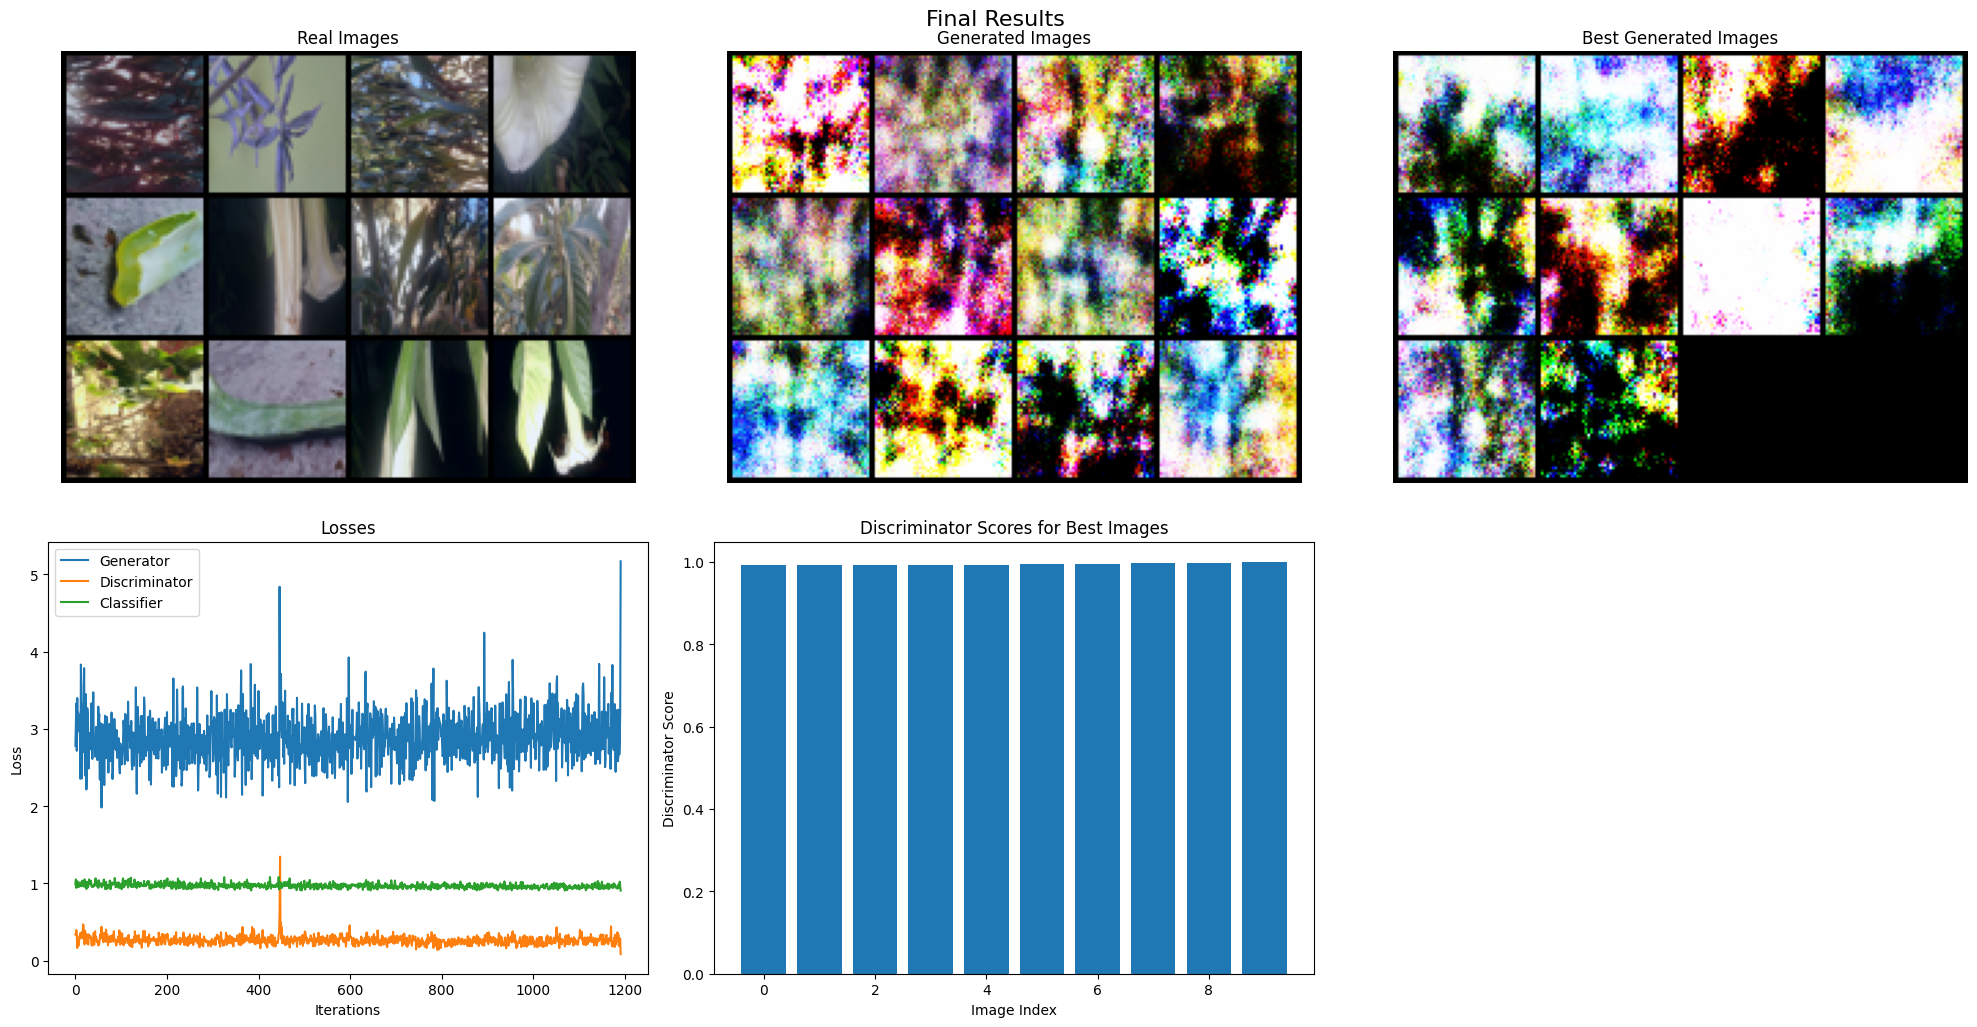

In [ ]:
# Now you can call your train function with the updated start_epoch
train(epochs=35, start_epoch=start_epoch)